## Task 1

###    For every column in the data:
 
### a. State whether the values match the description given in the table above.

### b. State the number of missing values in the column.

### c. Describe what you did to make values match the description if they did not
### match.

- **claim_id** - No changes were made to this column as missing values are not possible and there are no duplicates.

- **time_to_close** - Column has data type INTEGER. No changes were made to this column as all values were formatted as expected. There were no missing values or negative values. 

- **claim_amount** - There were no missing values. Removed 'R$' from all records in this column. Column was altered to data type DECIMAL.

- **amount_paid** - Column was altered to data type DECIMAL. There were 36 missing values, which were replaced with the median of the amount_paid column. (R$20105.70)

- **location** - Column has data type VARCHAR. No changes were made to this column as there were no missing values and all values were formatted as expected.

- **individuals_on_claim** - Column has data type INTEGER. No changes were made to this column as there were no missing values and all values were formatted as expected. All values are between 1 and 15.

- **linked_cases** - Column was altered to data type BOOLEAN. There were 26 missing values, which were replaced with FALSE.

- **cause** - Column has data type VARCHAR. Altered values in 30 affected rows to match the expected lowercase, singular format of this column. There were no missing values.


In [10]:
-- code for validation, followed by written answers
CREATE TABLE vivendo_claims (
claim_id INTEGER PRIMARY KEY,
	time_to_close INTEGER,
	claim_amount VARCHAR(160),
	amount_paid VARCHAR(160),
	location VARCHAR(160) NOT NULL,
	individuals_on_claim INTEGER NOT NULL DEFAULT(0),
	linked_cases VARCHAR(160),
	cause VARCHAR(160) NOT NULL DEFAULT('unknown')
);

COPY vivendo_claims FROM 'food_claims_2212.csv' DELIMITER ',' CSV HEADER;

-- time_to_close
SELECT * FROM vivendo_claims WHERE time_to_close IS NULL;
SELECT * FROM vivendo_claims WHERE time_to_close < 0;

--claim_amount
UPDATE vivendo_claims
SET claim_amount = (SELECT LTRIM(claim_amount, 'R$'));

ALTER TABLE vivendo_claims 
ALTER COLUMN claim_amount TYPE DECIMAL(10,2);

--amount_paid
UPDATE vivendo_claims
SET amount_paid = NULL
WHERE amount_paid = 'NA';

ALTER TABLE vivendo_claims 
ALTER COLUMN amount_paid TYPE DECIMAL(10,2);

UPDATE vivendo_claims
SET amount_paid = (SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY amount_paid) FROM vivendo_claims)
WHERE amount_paid IS NULL;

-- location
SELECT * FROM vivendo_claims
WHERE location NOT IN ('RECIFE', 'SAO LUIS','FORTALEZA','NATAL');

SELECT * FROM vivendo_claims
WHERE location is NULL;

-- individuals_on_claim
SELECT * FROM vivendo_claims WHERE individuals_on_claim IS NULL;
SELECT * FROM vivendo_claims WHERE individuals_on_claim < 1;

-- linked_cases
UPDATE vivendo_claims
SET linked_cases = NULL
WHERE linked_cases = 'NA';

ALTER TABLE vivendo_claims 
ALTER COLUMN linked_cases TYPE BOOLEAN;

UPDATE vivendo_claims
SET linked_cases = FALSE
WHERE linked_cases IS NULL;

SELECT count(*) FROM vivendo_claims WHERE linked_cases IS NULL;

-- cause
UPDATE vivendo_claims
SET cause = 'vegetable'
WHERE cause ILIKE '%vegetable%';

UPDATE vivendo_claims
SET cause = 'meat'
WHERE cause ILIKE '%meat%';

SELECT * FROM vivendo_claims
WHERE cause NOT IN ('unknown','vegetable','meat');

SELECT * FROM vivendo_claims;



,claim_id,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
0,1,317,74474.55,51231.37,RECIFE,15,False,unknown
1,2,195,52137.83,42111.30,FORTALEZA,12,True,unknown
2,3,183,24447.20,23986.30,SAO LUIS,10,True,meat
3,4,186,29006.28,27942.72,FORTALEZA,11,False,meat
4,5,138,19520.60,16251.06,RECIFE,11,False,vegetable
...,...,...,...,...,...,...,...,...
1995,1996,176,28982.30,24265.02,RECIFE,10,False,meat
1996,1997,166,5188.44,4772.77,FORTALEZA,2,True,meat
1997,1998,179,11975.85,10087.81,RECIFE,4,True,meat
1998,1999,162,23516.28,23310.24,RECIFE,9,False,meat


## Task 2

### Create a visualization that shows the number of claims in each location. Use the
### visualization to:

### a. State which category of the variable location has the most observations

### b. Explain whether the observations are balanced across categories of the
### variable location


**A.** The legal office in RECIFE has the most claims of all 4 offices, totaling 885 claims.

**B.** The number of claims at each location is unbalanced, as 44.25% of all claims were processed at the Recife location. This is more than twice the number of claims at both the Fortaleza and Natal offices, which have 311 claims and 289 claims respectively. The legal team should investigate why the Recife office has such a disproportionate number of claims.


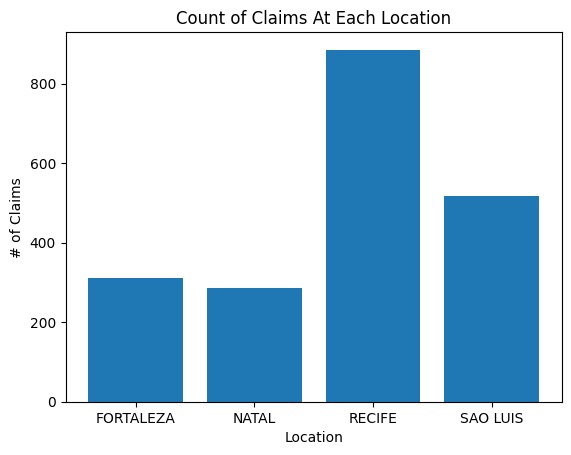

In [3]:
import matplotlib.pyplot as plt

vivendo_locations = vivendo_claims.groupby('location').count()

fig, ax = plt.subplots()
ax.bar(vivendo_locations.index, vivendo_locations['claim_id'])
ax.set_xlabel("Location")
ax.set_ylabel("# of Claims")
ax.set_title('Count of Claims At Each Location')
plt.show()


In [4]:
SELECT location AS Location, concat(count(*)::string, ' claims') AS 'Number of Claims'
FROM vivendo_claims
GROUP BY location
ORDER BY count(*) DESC;

,Location,Number of Claims
0,RECIFE,885 claims
1,SAO LUIS,517 claims
2,FORTALEZA,311 claims
3,NATAL,287 claims


## Task 3

### Describe the distribution of time to close for all claims. Your answer must include a
### visualization that shows the distribution.


   The range of the number of days it takes to close a claim appears slightly skewed to the right.  Most of the claims are solved within 300 days, but 53 claims took longer to do so, 6 of which exceeded 400 days. 
   
   The mean, median, and mode of the data are all within a 10-day range, and that range is clearly reflected by the value of the peak of the distribution. However, the mean being the largest value and the mode being the smallest value are representative of the presence of extreme values on the right end of the data. Additionally, the distribution has a narrow curve, which implies that claims are typically solved within timeframes comparable to the median value. 
   
   These details indicate that longer timeframes are atypical, uncommon occurrences. The legal team should look individually at the longest-standing claims to discern a reason for their longevity.

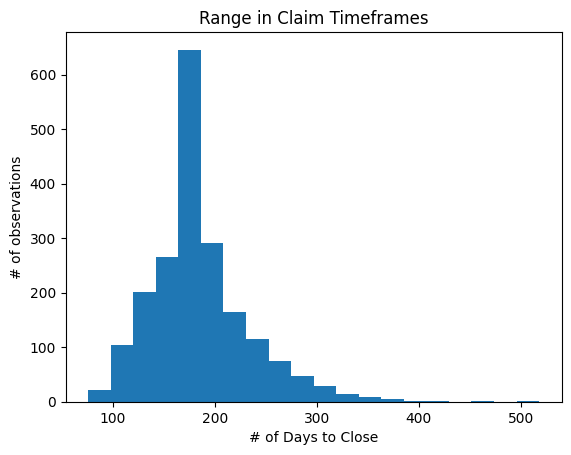

In [5]:
fig, ax = plt.subplots()
ax.hist(vivendo_claims['time_to_close'], bins = 20)
ax.set_xlabel('# of Days to Close')
ax.set_ylabel('# of observations')
ax.set_title('Range in Claim Timeframes')
plt.show()

In [6]:
SELECT count(*) FROM vivendo_claims
WHERE time_to_close > 300;

SELECT count(*) FROM vivendo_claims
WHERE time_to_close > 400;

SELECT concat(cast(avg(time_to_close) AS integer)::string, ' days') AS Mean,
concat(percentile_disc(0.5) WITHIN GROUP (ORDER BY time_to_close)::string, ' days') AS Median,
concat(MODE() WITHIN GROUP (ORDER BY time_to_close)::string, ' days') AS Mode
FROM vivendo_claims


,Mean,Median,Mode
0,186 days,179 days,176 days


In [7]:
SELECT location AS Location, concat(time_to_close::string, ' days') AS 'Longest Claims'
FROM vivendo_claims
WHERE time_to_close > 400
ORDER BY time_to_close DESC;

,Location,Longest Claims
0,SAO LUIS,518 days
1,SAO LUIS,499 days
2,FORTALEZA,453 days
3,RECIFE,427 days
4,SAO LUIS,419 days
5,FORTALEZA,406 days


## Task 4

### Describe the relationship between time to close and location. Your answer must
### include a visualization to demonstrate the relationship.


The range of timeframes are very similar across all the locations. The difference in interquartile ranges for all 4 locations is only 5 days, and the difference in their medians is even smaller. The plots for each location indicate that 75% of all claims are processed in just over 200 days or less. 

The Sao Luis office had the 2 claims with the longest closing times, at 518 days and 499 days respectively. However, the Fortaleza and Recife offices appear along with Sao Luis in the list of claims longer than 400 days, as mentioned above. This suggests that long timeframes are not an issue limited to the Sao Luis office. 

Overall, the 4 locations close their claims in timeframes that are comparable and without concerning differences. The legal team could investigate the procedures of the Natal office to see if there is anything the other offices can implement to avoid long-standing claims. 

Additionally, the concentration of outliers on the right end of the plots further suggests that timeframes longer than 300 days are uncommon even across the different locations. Once again, looking at these claims individually would provide the legal team more insight as to a reason for their longevity. 

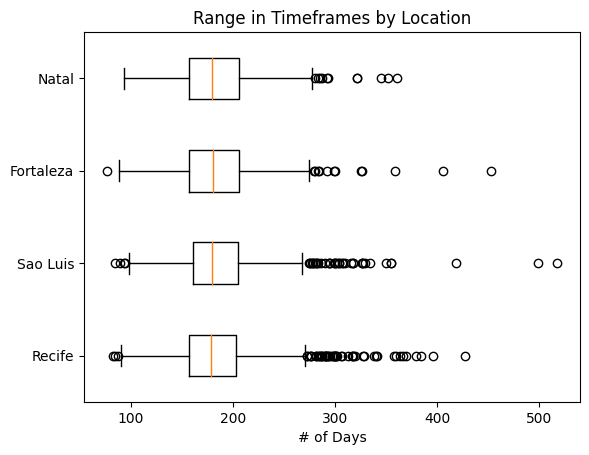

In [8]:
vivendo_recife = vivendo_claims[vivendo_claims['location'] == 'RECIFE']
vivendo_sao_luis = vivendo_claims[vivendo_claims['location'] == 'SAO LUIS']
vivendo_fortaleza = vivendo_claims[vivendo_claims['location'] == 'FORTALEZA']
vivendo_natal = vivendo_claims[vivendo_claims['location'] == 'NATAL']

fig, ax = plt.subplots()
ax.boxplot([vivendo_recife['time_to_close'],vivendo_sao_luis['time_to_close'],vivendo_fortaleza['time_to_close'],vivendo_natal['time_to_close']], vert=False)
ax.set_yticklabels(['Recife', 'Sao Luis', 'Fortaleza', 'Natal'])
ax.set_xlabel('# of Days')
ax.set_title('Range in Timeframes by Location')
plt.show()

In [9]:
SELECT concat((max(median) - min(median))::string, ' days') AS 'Difference of Medians',
concat((max(IQR) - min(IQR)):: string, ' days') AS 'Difference of IQRs',
concat(max(Third_Quartile)::string, ' days') AS 'Greatest Q3'
FROM
(SELECT location AS Location, 
percentile_disc(0.5) WITHIN GROUP (ORDER BY time_to_close) AS Median,
(percentile_disc(0.75) WITHIN GROUP (ORDER BY time_to_close) - percentile_disc(0.25) WITHIN GROUP (ORDER BY time_to_close)) AS IQR,
percentile_disc(0.75) WITHIN GROUP (ORDER BY time_to_close) AS Third_Quartile
FROM vivendo_claims
GROUP BY location) AS first_query;


,Difference of Medians,Difference of IQRs,Greatest Q3
0,2 days,5 days,206 days
